In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import urllib.request
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [156]:
# Import data

#Define the url and the file name to retrieve
url = 'https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv'
file_name = 'insurance.csv'

#For security reasons it is necessary to add a user_agent header to simulate a browser request
header = {'User-Agent': 'Mozilla/5.0'}
req = urllib.request.Request(url, headers=header)

#Make the request and read the file
with urllib.request.urlopen(req) as response, open(file_name, 'wb') as out_file:
    data = response.read()
    out_file.write(data)

#Load the dataset to our DataFrame
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


# EDA

In [157]:
# Let's copy the DataFrame to a new one so I always have the original
df_eda = dataset.copy()

In [158]:
df_eda.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [159]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [160]:
df_eda.describe()
# By looking at the results it doesn't seem to be any absurd value on the numerical columns
# We have a max for the bmi of 53, which is too much, but it can be a real value

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


<Axes: xlabel='bmi'>

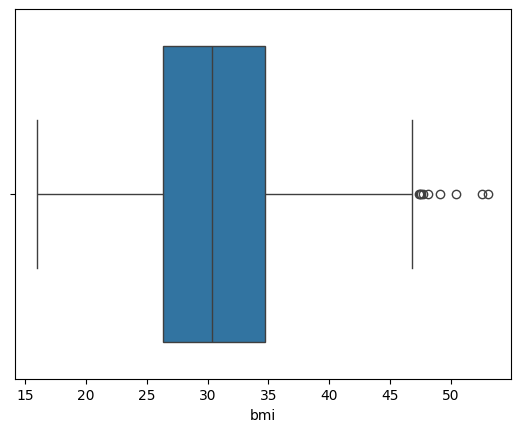

In [161]:
# Let's check for outliers

sns.boxplot(data=df_eda, x='bmi')
#sns.boxplot(data=df_eda, x='age')
#sns.boxplot(data=df_eda, x='children')
#sns.boxplot(data=df_eda, x='expenses')

#There are some outliers in "bmi" and "expenses" but I'll not discard them for now

In [162]:
#Let's check the unique values of the categorical columns to see if there is a mistake in any of them

print(df_eda['sex'].unique(), df_eda['smoker'].unique(), df_eda['region'].unique())
# It seems correct

['female' 'male'] ['yes' 'no'] ['southwest' 'southeast' 'northwest' 'northeast']


In [163]:
# Now I want to evaluate the relation between variables, for that I need to transform the categorical variables into numerical
# I'll use pandas for now

df_eda = pd.get_dummies(df_eda, columns=['sex', 'smoker', 'region'], dtype='int64')

<Axes: >

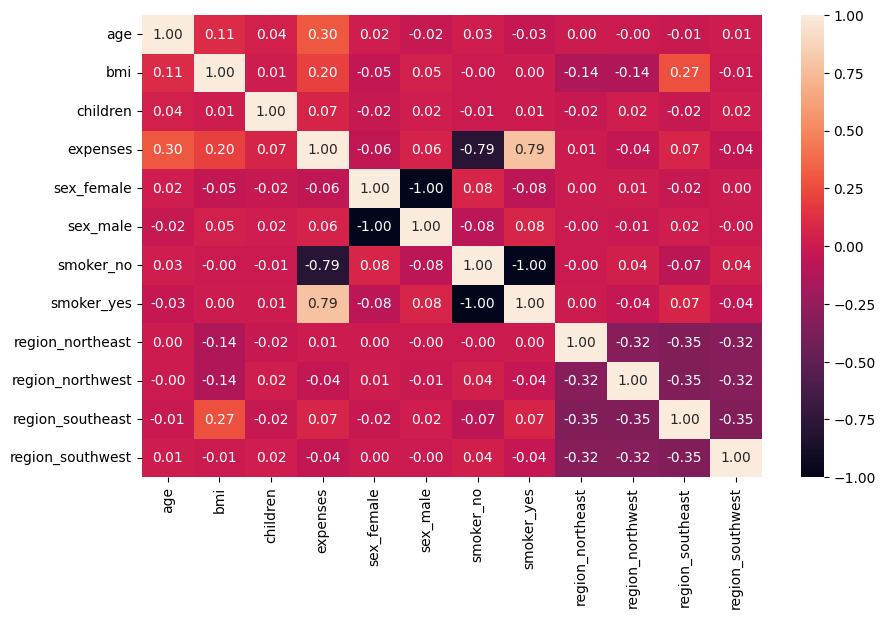

In [164]:
# To see the correlation between all the variables we can use a heatmap

plt.figure(figsize=(10,6))
sns.heatmap(df_eda.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')


<Axes: >

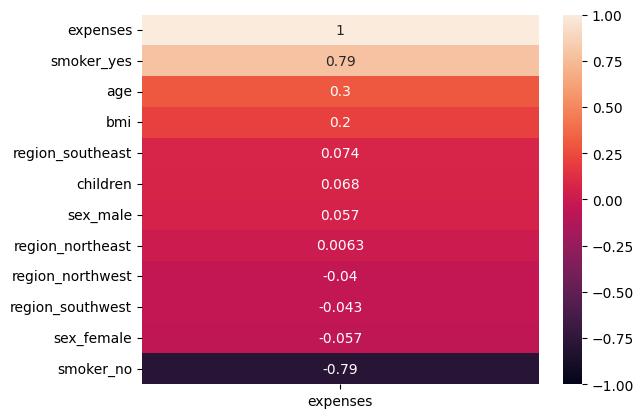

In [165]:
#Focusing on the target variable "expenses"
sns.heatmap(df_eda.corr()[['expenses']].sort_values(by='expenses', ascending=False), vmin=-1, vmax=1, annot=True)

#as we can see the "expenses" (the target variable) as high correlation with "smoker"
# a mild correlation with "age" and "bmi"
# and a low correlation with the other variables

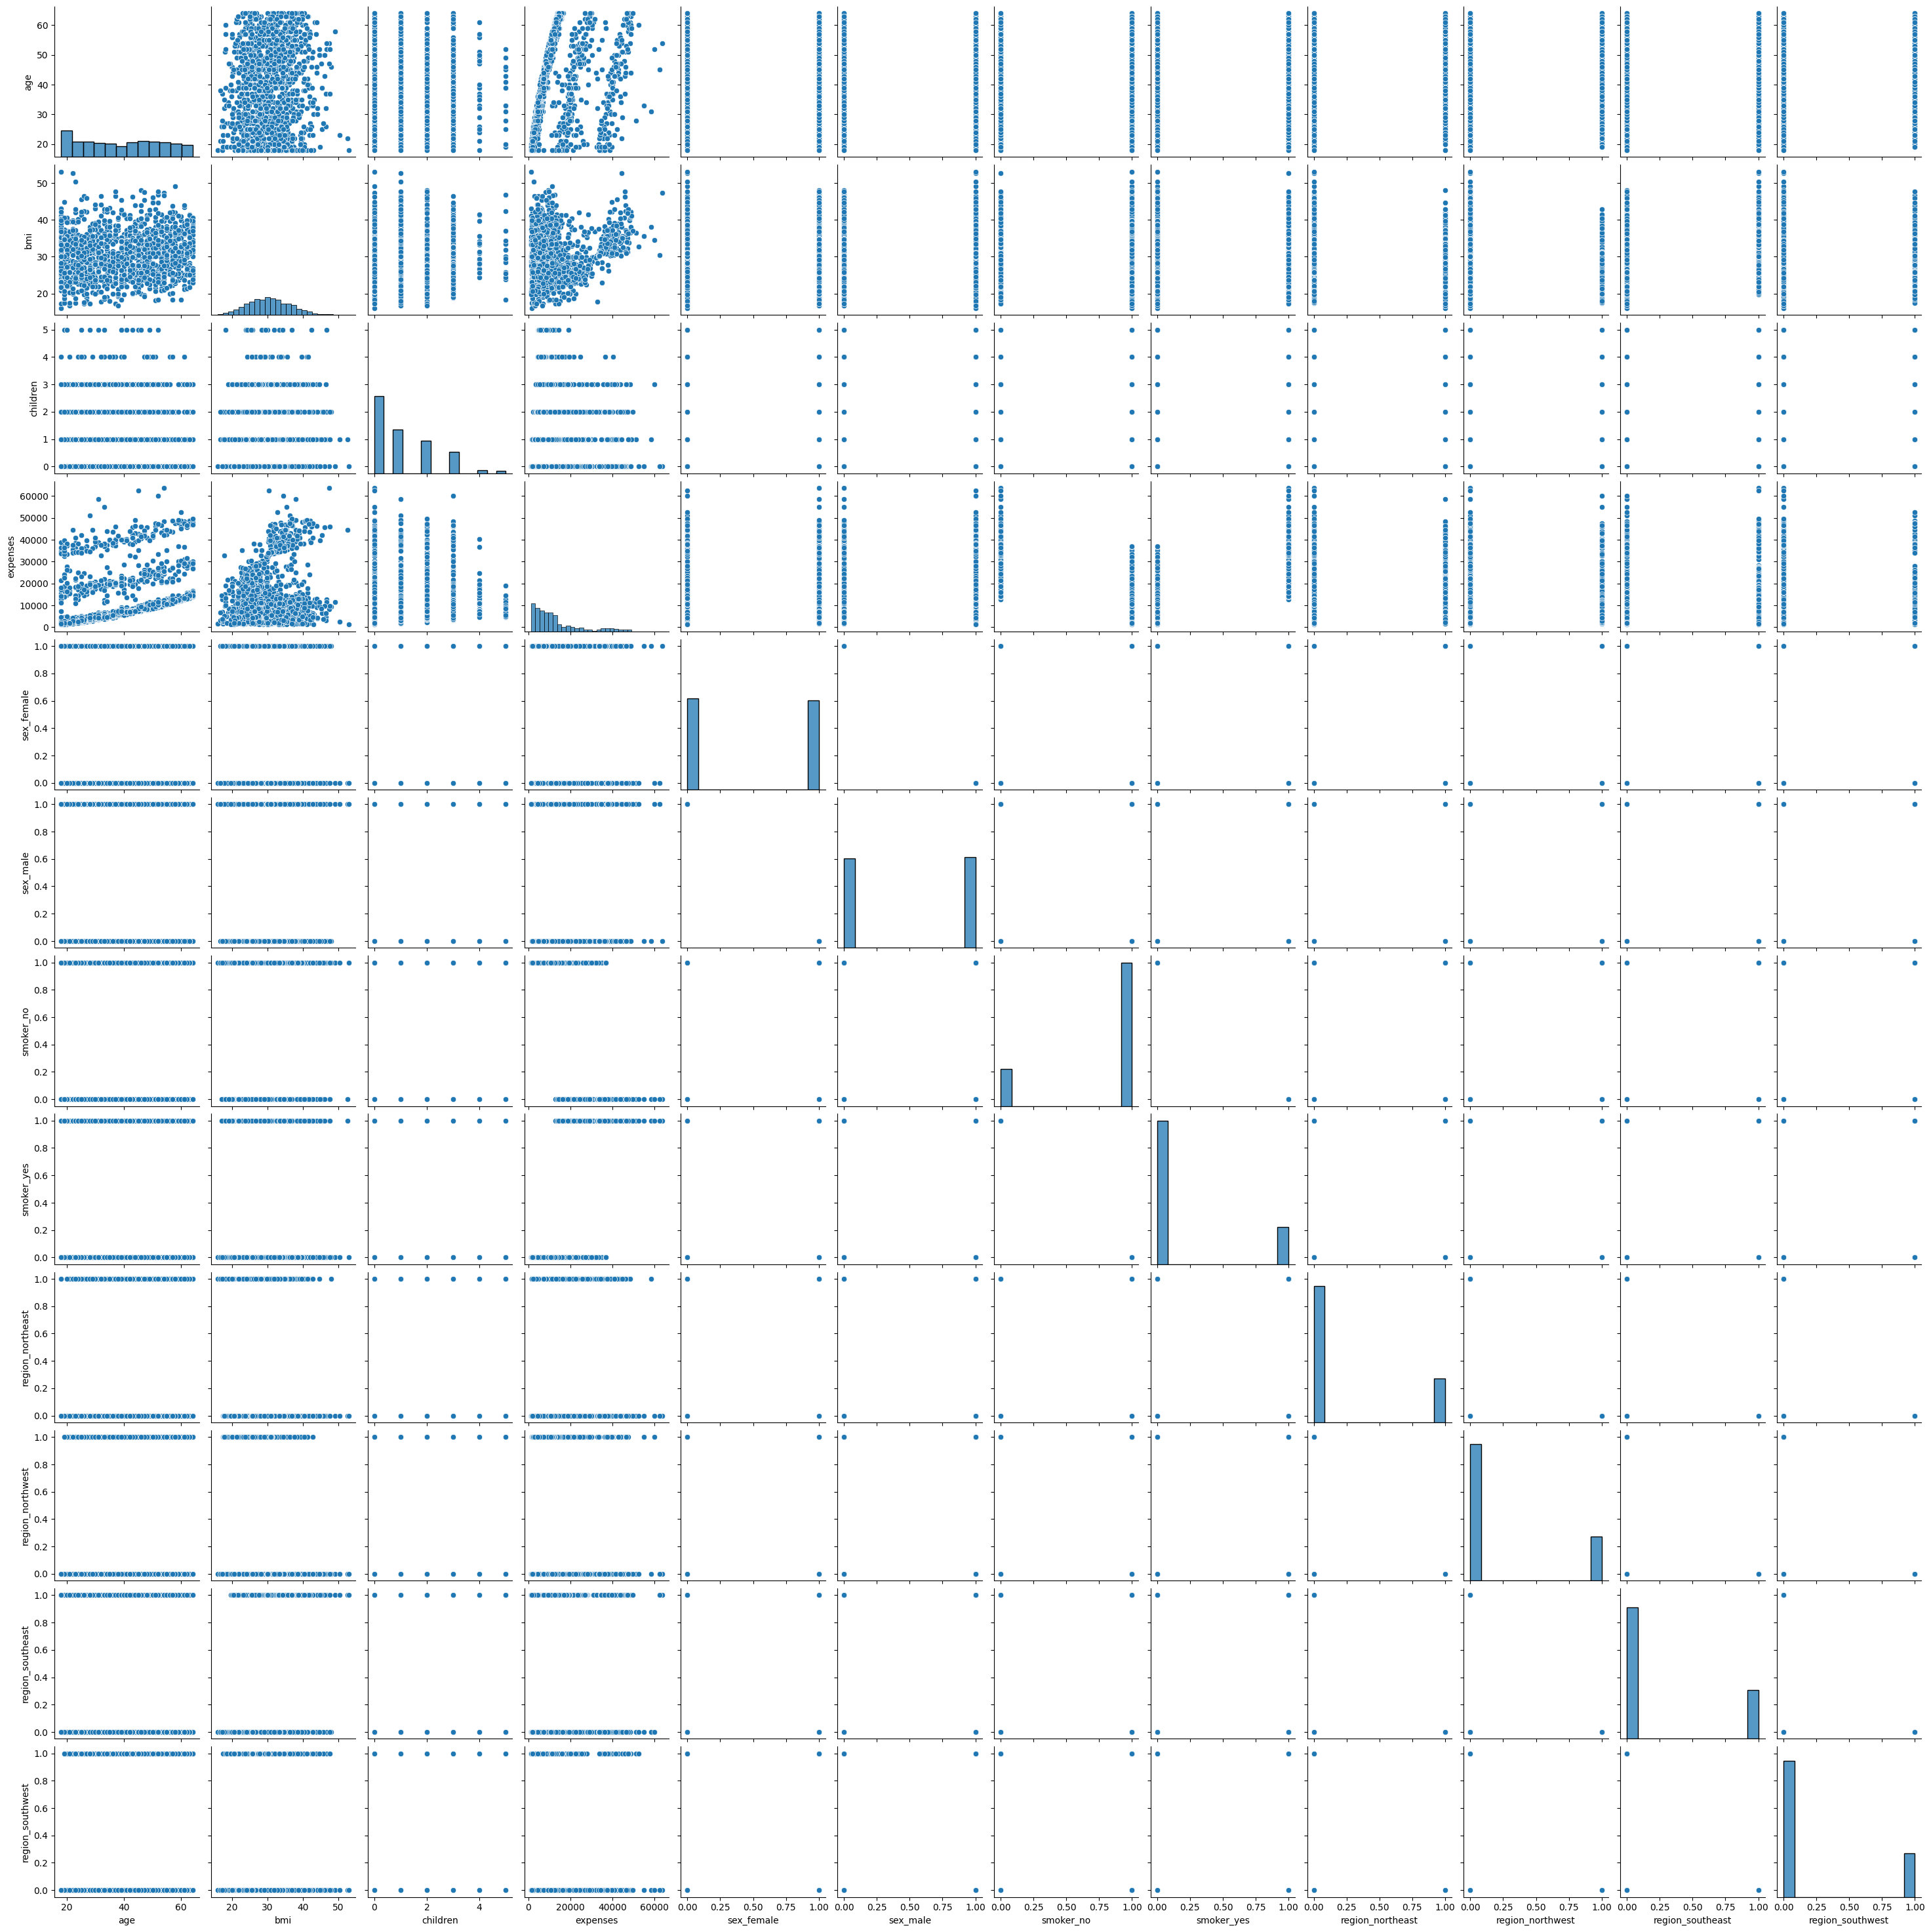

In [166]:
sns.pairplot(data=df_eda)
# We can see that the numerical variables do not follow a normal distribution (only "bmi"), so I'll process that as well

# Creating, training and testing the Model

In [167]:
#Since I couldn't achieve the desired mae, I've created this function to remove the outliers mentioned above to test if the model improved
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [168]:
#remove the outliers from bmi and expenses
dataset_cleaned = remove_outliers(dataset, 'bmi')
dataset_cleaned = remove_outliers(dataset_cleaned, 'expenses')

In [169]:
X = dataset_cleaned.drop(columns=['expenses'])
y = dataset_cleaned['expenses']

X_train, X_test, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42) 

In [170]:
# Encoding the Numerical and Categorical Columns 

categorical_columns = ['sex', 'smoker', 'region']
numerical_columns = ['age', 'bmi', 'children']

# Create the processor to transform the columns

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

In [171]:
train_dataset = preprocessor.fit_transform(X_train)
test_dataset = preprocessor.transform(X_test) #to apply the same transformations that were learned from the training data without refitting

In [172]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(train_dataset.shape[1],)))
model.add(keras.layers.Dense(10, activation='linear'))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'mse',
    metrics = ['mae', 'mse']
)

In [173]:
model.fit(train_dataset, train_labels, batch_size=25, epochs=50)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 146874816.0000 - mae: 9687.7988 - mse: 146874816.0000
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128084920.0000 - mae: 8828.1104 - mse: 128084920.0000
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70064808.0000 - mae: 5405.6357 - mse: 70064808.0000
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45086492.0000 - mae: 4359.1538 - mse: 45086492.0000
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34722792.0000 - mae: 4289.0083 - mse: 34722792.0000
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37180936.0000 - mae: 4387.1348 - mse: 37180936.0000
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30981050.0000 - mae: 3717.2805 - mse: 30981050.0000
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27616920.0000 - mae: 3566.0205 - mse: 27616922.0000
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27316054.0000 - mae: 3572.0872 - mse: 27316054.0000
Epoch 

8/8 - 0s - 32ms/step - loss: 19770360.0000 - mae: 2642.1064 - mse: 19770360.0000
Testing set Mean Abs Error: 2642.11 expenses
You passed the challenge. Great job!
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


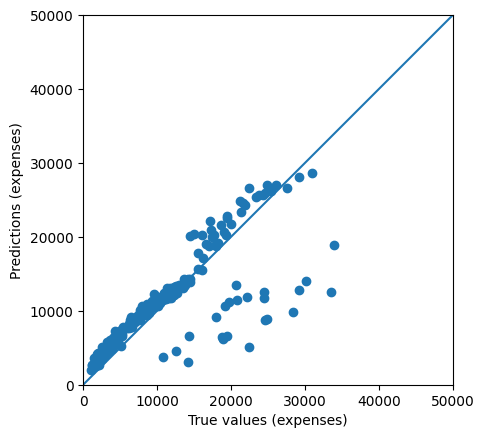

In [174]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)